# Human Activity Recognition - AWS

### Problem Statement
Let’s open the notebook “HAR Model training notebook”. The problem statement for this notebook is: Deploying the Human Activity Recognition problem using the Level 1 MLOps architecture, the aim is to enhance the experience of Blackmi's health app by overcoming the problems faced in the level 0 architecture. Utilising the Human Activity Recognition dataset, we will construct a machine-learning model along with the ML pipelines to categorise user activities for the real-time health alerts using AWS sagemaker studio. Here we will also be monitoring the model performance and deploy the model using different deployment techniques.

### Approach 
In this notebook we will be building the level 1 architecture of MLOps, and our major focus would be on creating ML pipeline, model monitoring and model deployment. The major take away for this lesson is to learn:

1. Feature engineering with the amazon sagemaker processing 



## 1. Importing the Libraries and Dataset 

In [1]:
# Importing all the necessary libraries 
# Importing pandas and numpy for data preprocessing. 
import pandas as pd
import numpy as np
# Boto3 is used for launching the EC2 instances and manipulating s3 buckets.
import boto3
# Sagemaker is imported for building, training and deploying machine learning models.
import sagemaker


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Initialising new sagemaker session as "sess".
sess = sagemaker.Session()
# Check for necessary permission needed for training and deploying models. 
role = sagemaker.get_execution_role()
# To understand where this session is configured to operate.
region = boto3.Session().region_name
region


'us-east-1'

In [3]:
bucket = sess.default_bucket()
bucket

'sagemaker-us-east-1-825765393939'

In [4]:
# Bucket variable is used for storing the location of the bucket
bucket = sess.default_bucket()
# Assigning the prefix variable 
prefix = 'mlops-human-activity-recognition'
###
input_source = f's3://{bucket}/{prefix}/data/data.csv'

In [5]:
# Reading the dataset using the read_parquet format.
df = pd.read_csv(input_source)
df.shape


(7352, 563)

In [6]:
# Displaying first few rows of the dataset
df.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


Text(0, 0.5, 'Activity Count')

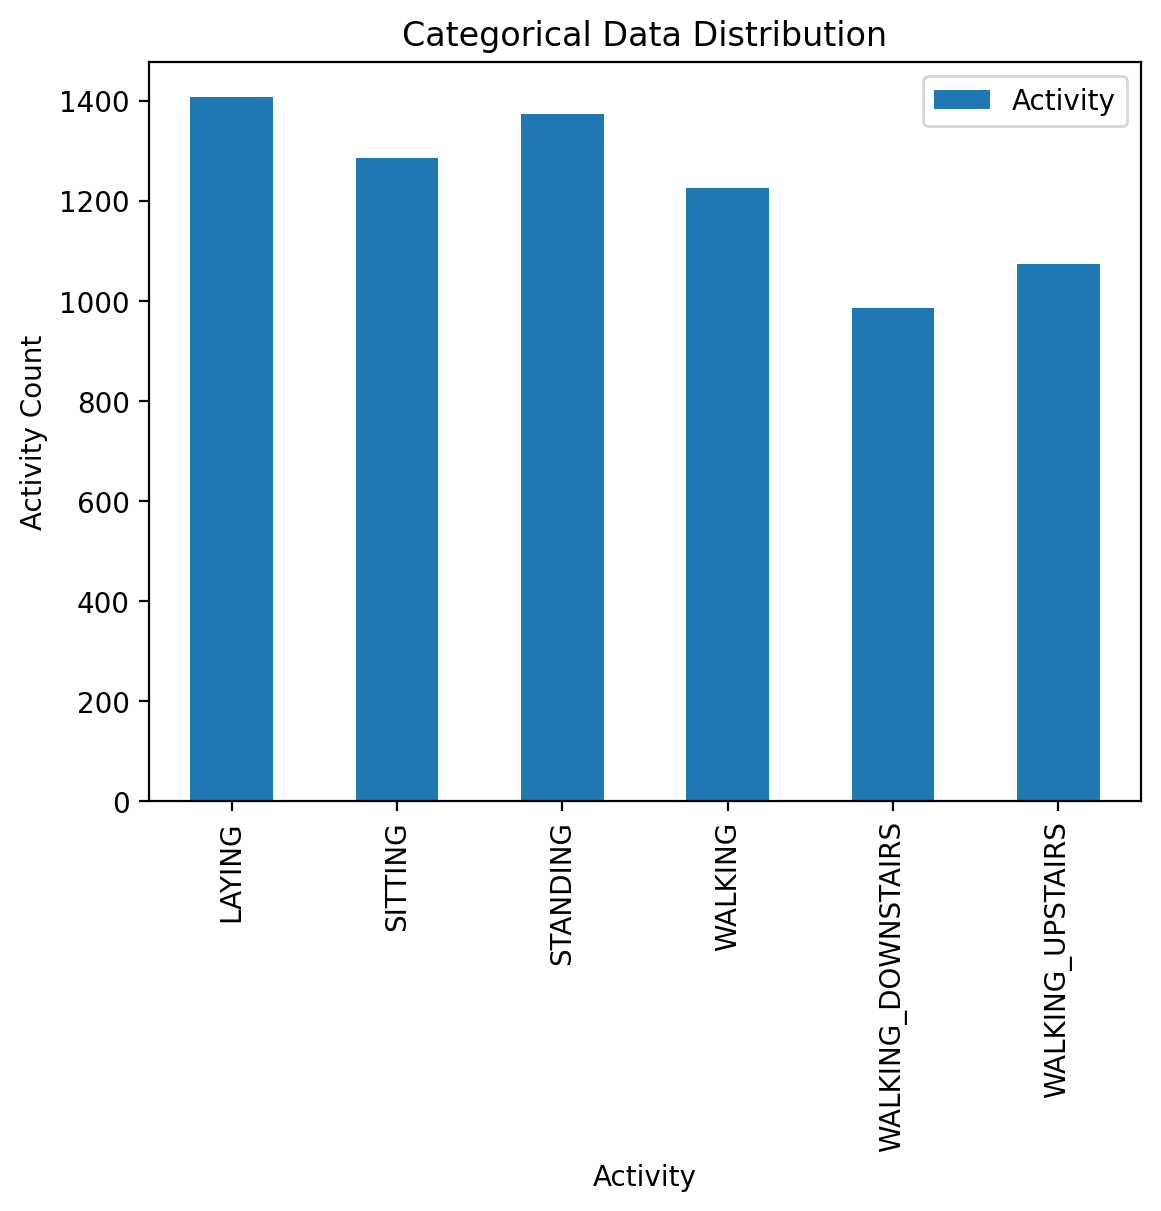

In [7]:
# Visualising the data distribution of the Activity column
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df.groupby("Activity")[['Activity']].count().plot(kind="bar", title="Categorical Data Distribution")
plt.xlabel("Activity")
plt.ylabel("Activity Count")


## 2. Orchestrated Experiment (Feature Engineering with Amazon SageMaker Processing)

### 2.1 Data Pipeline 

In [16]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
def _parse_args():

    parser = argparse.ArgumentParser()
    
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='data.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')

    return parser.parse_known_args()

# Defining a function to extract the top k features 
def get_top_k_features(X, Y, k):
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X, Y)
        feature_df = pd.DataFrame(
            data=(X.columns, clf.feature_importances_)
        ).T.sort_values(by=1, ascending=False)
        cols = feature_df.head(k)[0].values
        return cols

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load data
    path = os.path.join(args.filepath,args.filename)
    print(path)
    
    # Reading the dataset and performing label encoding 
    df = pd.read_csv(os.path.join(args.filepath,args.filename))
    df.dropna(inplace = True)
    le = LabelEncoder()
    df['Activity'] = le.fit_transform(df['Activity'])

    # Assignining the indepeneded and depended variable 
    X = df.drop(['Activity'], axis =1)
    Y = df['Activity']
    
    # Extracting top 12 important feature and filtering the dataset
    k =12
    final_cols = get_top_k_features(X, Y, k)
    final_cols = np.append(final_cols,np.array(['Activity']))
    df = df[final_cols]
    
    # Train, test, validation split
    # Randomly sort the data then split out first 70%, second 20%, and last 10%
    train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(0.8 * len(df)), int(0.9 * len(df))])  
    
    # Storing of train, validation and test datasets 
    pd.concat([train_data['Activity'], train_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    pd.concat([validation_data['Activity'], validation_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[['Activity']].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop(['Activity'], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    ## Save Features columns
    dump(final_cols, os.path.join(args.outputpath, 'feature/feature.joblib'))
    ## Save Encoder
    dump(le, os.path.join(args.outputpath, 'feature/encoder.joblib'))
    
    print("## Processing complete. Exiting.")

Overwriting preprocessing.py


In [17]:
train_path = f"s3://{bucket}/{prefix}/train"
validation_path = f"s3://{bucket}/{prefix}/validation"
test_path = f"s3://{bucket}/{prefix}/test"
feature_path = f"s3://{bucket}/{prefix}/feature"

In [18]:
# Importing necessary library for data processing 
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=get_execution_role(),
    instance_type="ml.t3.medium",
    instance_count=1, 
    base_job_name='sklearn-data-preprocessing'
)

sklearn_processor.run(
    code='preprocessing.py',
    inputs=[
        ProcessingInput(
            source=input_source, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_path,
        ),
        ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/output/validation", destination=validation_path),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/output/test", destination=test_path),
        ProcessingOutput(output_name="feature_data", source="/opt/ml/processing/output/feature", destination=feature_path)
    ]
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating processing-job with name sklearn-data-preprocessing-2024-11-22-06-39-47-213


................/opt/ml/processing/input/data.csv
## Processing complete. Exiting.



## 2.2 Training

In [19]:
s3_input_train = sagemaker.TrainingInput(s3_data=train_path.format(bucket, prefix), 
                                                    content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data=validation_path.format(bucket, prefix),
                                                     content_type='csv')

In [20]:
# Model pipeline

In [21]:
%%writefile sklearn-train.py 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import dump, load
import pandas as pd, numpy as np, os, argparse

## predict 

# inference function - tells SageMaker how to load the model
def model_fn(model_dir):
    clf = load(os.path.join(model_dir, "model.joblib"))
    return clf    
        
# Argument parser
def _parse_args():
    parser = argparse.ArgumentParser()
    # Hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)
    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    # Parse the arguments
    return parser.parse_known_args()

# Main Training Loop
if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load the dataset
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    # Separate X and y
    X_train, y_train = train_df.drop(train_df.columns[0], axis=1), train_df[train_df.columns[0]]
    X_test, y_test = test_df.drop(test_df.columns[0], axis=1), test_df[test_df.columns[0]]
    # Define the model and train it
    model = RandomForestClassifier(
        n_estimators=args.n_estimators, n_jobs=-1
    )
    model.fit(X_train, y_train)
    # Evaluate the model performances
    print(f'Model Accuracy: {accuracy_score(y_test, model.predict(X_test))}')
    dump(model, os.path.join(args.model_dir, 'model.joblib'))
    

Overwriting sklearn-train.py


In [22]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

# Define the Estimator from SageMaker (Script Mode)
sklearn_estimator = SKLearn(
    entry_point="sklearn-train.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "Accuracy", "Regex": "Accuracy: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 120,
        "min-samples-leaf": 3,
        "test-file": "validation.csv"
    },
)

# Train the model (~5 minutes)
sklearn_estimator.fit({"train": s3_input_train, "test": s3_input_validation})

INFO:sagemaker:Creating training-job with name: rf-scikit-2024-11-22-06-45-12-785


2024-11-22 06:45:14 Starting - Starting the training job...
2024-11-22 06:45:28 Starting - Preparing the instances for training...
2024-11-22 06:46:02 Downloading - Downloading input data...
2024-11-22 06:46:32 Downloading - Downloading the training image..2024-11-22 06:46:56,943 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-11-22 06:46:56,946 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-22 06:46:56,984 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-11-22 06:46:57,145 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-22 06:46:57,156 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-22 06:46:57,166 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-11-22 06:46:57,174 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "ad

## 2.3 Hyper Parameter

In [18]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "n-estimators": IntegerParameter(100, 200),
    "min-samples-leaf": IntegerParameter(2, 6)
}

Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name="RF-tuner",
    objective_type="Maximize",
    objective_metric_name="Accuracy",
    metric_definitions=[
        {"Name": "Accuracy", "Regex": "Accuracy: ([0-9.]+).*$"}
    ],  # extract tracked metric from logs with regexp
    max_jobs=10,
    max_parallel_jobs=2,
)

In [19]:
Optimizer.fit({"train": s3_input_train, "test": s3_input_validation})

Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: RF-tuner-231107-0928


.........................................................................................!


In [20]:
# get tuner results in a df
results = Optimizer.analytics().dataframe()
while results.empty:
    time.sleep(1)
    results = Optimizer.analytics().dataframe()
results.head()


,min-samples-leaf,n-estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,2.0,115.0,RF-tuner-231107-0928-010-568fbefe,Completed,0.832383,2023-11-07 09:35:04+00:00,2023-11-07 09:35:45+00:00,41.0
1,3.0,115.0,RF-tuner-231107-0928-009-e1b632f5,Completed,0.832983,2023-11-07 09:34:56+00:00,2023-11-07 09:35:48+00:00,52.0
2,3.0,116.0,RF-tuner-231107-0928-008-7c9ed9d6,Completed,0.831883,2023-11-07 09:34:08+00:00,2023-11-07 09:34:50+00:00,42.0
3,3.0,118.0,RF-tuner-231107-0928-007-f253136d,Completed,0.834183,2023-11-07 09:33:54+00:00,2023-11-07 09:34:40+00:00,46.0
4,3.0,109.0,RF-tuner-231107-0928-006-94aa02cd,Completed,0.831983,2023-11-07 09:32:49+00:00,2023-11-07 09:33:35+00:00,46.0


## 2.4 Sagemaker XGboost

In [32]:
import sagemaker
import boto3
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

# initialize hyperparameters
hyperparameters = {
        "eval_metric":"balanced_accuracy",
        "num_class":6,
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"multi:softmax",
        "num_round":"150"}

# set an output path where the trained model will be saved
#bucket = sagemaker.Session().default_bucket()
#prefix = 'DEMO-xgboost-as-a-built-in-algo'
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'xgb-HAR-MulticlassificationModel')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# construct a SageMaker estimator that calls the xgboost-container
xgboost_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "text/csv"#"libsvm"
train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'validation'), content_type=content_type)

# execute the XGBoost training job
xgboost_estimator.fit({'train': train_input, 'validation': validation_input})


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-07-11-07-08-936


2023-11-07 11:07:09 Starting - Starting the training job...
2023-11-07 11:07:25 Starting - Preparing the instances for training......
2023-11-07 11:08:31 Downloading - Downloading input data...
2023-11-07 11:08:56 Training - Downloading the training image...
2023-11-07 11:09:16 Training - Training image download completed. Training in progress..[2023-11-07 11:09:38.255 ip-10-2-211-22.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-11-07 11:09:38.277 ip-10-2-211-22.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-11-07:11:09:38:INFO] Imported framework sagemaker_xgboost_container.training
[2023-11-07:11:09:38:INFO] Failed to parse hyperparameter eval_metric value balanced_accuracy to Json.
Returning the value itself
[2023-11-07:11:09:38:INFO] Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
[2023-11-07:11:09:38:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-07:11

## Hosting

In [23]:
from sagemaker.model_monitor import DataCaptureConfig

# Set to True to enable data capture
enable_capture = True

# Optional - Sampling percentage. Choose an integer value between 0 and 100
sampling_percentage = 100
# sampling_percentage = 30 # Example 30%

# Optional - The S3 URI of stored captured-data location
s3_capture_upload_path =f"s3://{bucket}/{prefix}/datacapture/"

# Specify either Input, Output or both. 
capture_modes = ['REQUEST','RESPONSE'] # In this example, we specify both

# Configuration object passed in when deploying Models to SM endpoints
data_capture_config = DataCaptureConfig(
    enable_capture = enable_capture, 
    sampling_percentage = sampling_percentage, # Optional
    destination_s3_uri = s3_capture_upload_path, # Optional
    capture_options = ["REQUEST", "RESPONSE"],
)

In [24]:
from datetime import datetime

sklearn_endpoint_name =f"Sklearn-Inference-endpoint-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", sklearn_endpoint_name)

EndpointName = Sklearn-Inference-endpoint-2024-11-22-0649


### Deploying Sklearn Randomforest

In [25]:
initial_instance_count=1
# initial_instance_count=1 # Example

instance_type='ml.m4.xlarge'
# instance_type='ml.m4.xlarge' # Example

sklearn_predictor =sklearn_estimator.deploy(
    initial_instance_count=initial_instance_count,
    instance_type=instance_type,
    endpoint_name=sklearn_endpoint_name,
    data_capture_config=data_capture_config,
    wait = True
)

INFO:sagemaker:Creating model with name: rf-scikit-2024-11-22-06-49-58-775
INFO:sagemaker:Creating endpoint-config with name Sklearn-Inference-endpoint-2024-11-22-0649
INFO:sagemaker:Creating endpoint with name Sklearn-Inference-endpoint-2024-11-22-0649


-------!

### Real time Inference

In [26]:
#sklearn_endpoint_name = 'Sklearn-Inference-endpoint-2023-11-07-1111'

In [33]:
import json
def real_time_prediction(data,ENDPOINT_NAME):
    runtime= boto3.client('runtime.sagemaker')
    df = data.copy()
    n = df.shape[0]
    if n == 1:
        df = pd.concat([df,df])
    payload_data = df.to_csv(header=False, index=False).encode("utf-8")
    print(df.shape)
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                      ContentType='text/csv',
                                      Body=payload_data)

    result = json.loads(response['Body'].read().decode())
    
    preds = {"Prediction": result}
    if n == 1:
        preds = {'Prediction': preds['Prediction'][0]}
    response_dict = {
          "statusCode": 200,
          "body": json.dumps(preds)
                }
    return response_dict

In [28]:
test_path = f"s3://{bucket}/{prefix}/test"

In [29]:
test_x = pd.read_csv(test_path+ '/test_x.csv')

In [30]:
test_y = pd.read_csv(test_path+ '/test_y.csv')

In [31]:
test_x.head()

,0.90964761,0.82145643,0.91784581,0.93328399,-0.31182388,-0.3156575,0.29702062,-0.70932029,-0.8310076999999999,-0.25087752,-0.37023987,-0.55852449
0,0.821800,0.710577,0.907217,0.890019,-0.225711,-0.200213,0.238525,-0.642606,-0.916824,-0.243019,-0.339247,-0.584124
1,0.894454,0.914757,0.988839,0.969176,-0.138790,-0.113810,0.178523,-0.867724,-0.971884,-0.160540,-0.994377,-0.998782
2,0.885234,0.889019,0.978596,0.959439,-0.213585,-0.186879,0.229476,-0.803546,-0.926257,-0.232910,-0.993920,-0.994717
3,0.872308,0.855536,0.966717,0.946672,0.150606,0.172140,-0.020129,-0.833786,-0.945098,0.122008,-0.986032,-0.989809
4,-0.663052,-0.986210,-0.545005,-0.597225,0.825943,0.840351,-0.582228,0.678570,0.374255,0.777107,-0.992175,-0.993918


In [34]:

real_time_prediction(test_x.iloc[0:10],sklearn_endpoint_name)

(10, 12)


{'statusCode': 200, 'body': '{"Prediction": [3, 2, 2, 1, 0, 2, 0, 1, 0, 5]}'}

In [35]:
y_pred = real_time_prediction(test_x,sklearn_endpoint_name)

(735, 12)


In [36]:
y_pred = eval(y_pred['body'])['Prediction']

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       0.96      0.93      0.95       138
           2       0.94      0.96      0.95       141
           3       0.95      0.91      0.93       135
           4       0.86      0.91      0.89        82
           5       0.95      0.95      0.95       105

    accuracy                           0.95       735
   macro avg       0.94      0.95      0.94       735
weighted avg       0.95      0.95      0.95       735



### Deploying Sagemaker Xgboost

In [ ]:
model_url = f's3://{bucket}/{prefix}/xgb-HAR-MulticlassificationModel/output/sagemaker-xgboost-2023-11-07-11-07-08-936/output/model.tar.gz'

from sagemaker import image_uris

# Name of the framework or algorithm
framework='xgboost'
#framework='xgboost' # Example

# Version of the framework or algorithm
version = '1.7-1'
#version = '0.90-1' # Example

# Specify an AWS container image. 
container = image_uris.retrieve(region=region, 
                                framework=framework, 
                                version=version)

##
from sagemaker.model import Model

model = Model(image_uri=container, 
              model_data=model_url, 
              role=role)

##
xgboost_endpoint_name = f"Xgboost-Inference-endpoint-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", xgboost_endpoint_name)

##
initial_instance_count=1
# initial_instance_count=1 # Example

instance_type='ml.m4.xlarge'
# instance_type='ml.m4.xlarge' # Example

model.deploy(
    initial_instance_count=initial_instance_count,
    instance_type=instance_type,
    endpoint_name=xgboost_endpoint_name,
    data_capture_config=data_capture_config,
    wait = True
)

In [1]:
#pd.crosstab(index=test_y['y'].values, columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


In [182]:
###### END #######
